# scratch work

In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import corner
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from jorbit.utils.kepler import M_from_f, kepler

In [26]:
from jorbit.utils.reparameterizations import (
    orbital_elements_to_unit_cube,
    unit_cube_to_orbital_elements,
)

u = np.random.uniform(0, 1, (1_000_000, 7))
orbs = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0, None,None,None))(u, 1.0, 1000.0, False)
u_ = jax.vmap(orbital_elements_to_unit_cube, in_axes=(0, None,None,None))(orbs, 1.0, 1000.0, False)
print(jnp.max(jnp.abs(u - u_)))

u = np.random.uniform(0, 1, (1_000_000, 7))
orbs = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0, None,None,None))(u, 1.0, 1000.0, True)
u_ = jax.vmap(orbital_elements_to_unit_cube, in_axes=(0, None,None,None))(orbs, 1.0, 1000.0, True)
print(jnp.max(jnp.abs(u - u_)))

8.118061778361607e-12
2.4797885966876265e-11


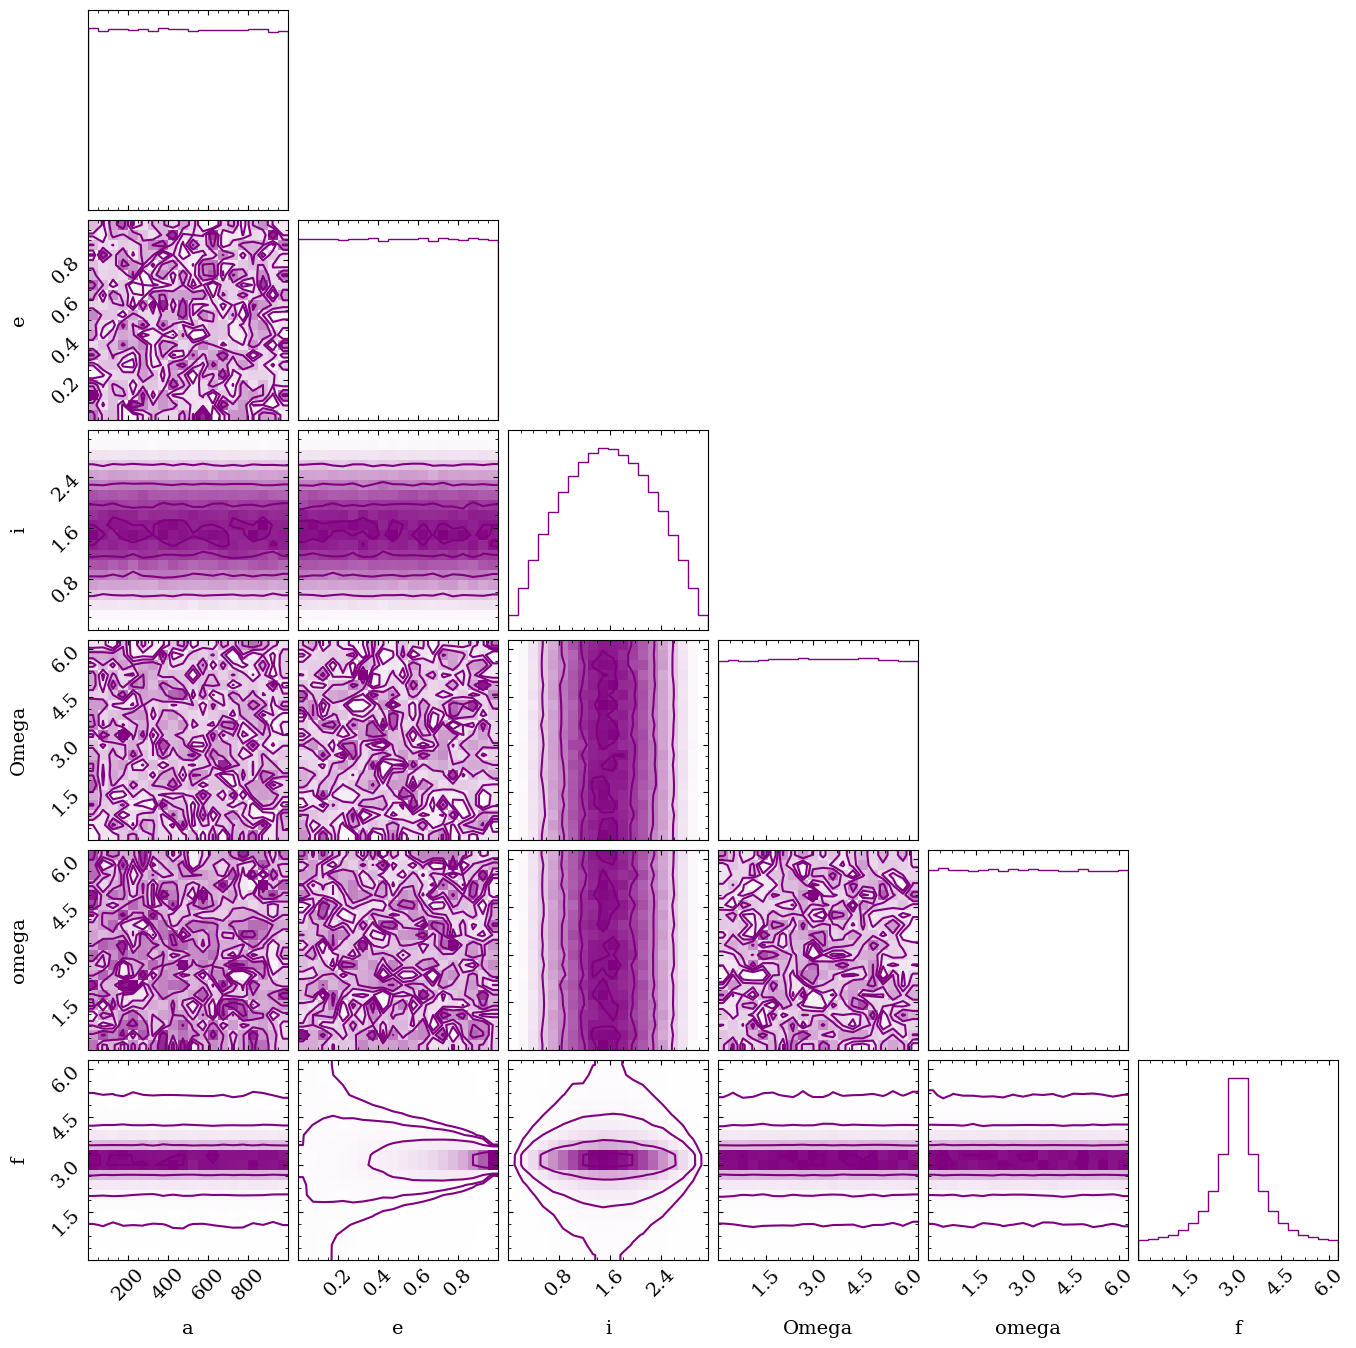

In [29]:
u = np.random.uniform(0, 1, (1_000_000, 7))
orbs = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0, None,None,None))(u, 1.0, 1000.0, False)

corner.corner(np.array(orbs[:,:-1]), labels=['a', 'e', 'i', 'Omega', 'omega', 'f'], color="purple", plot_datapoints=False);

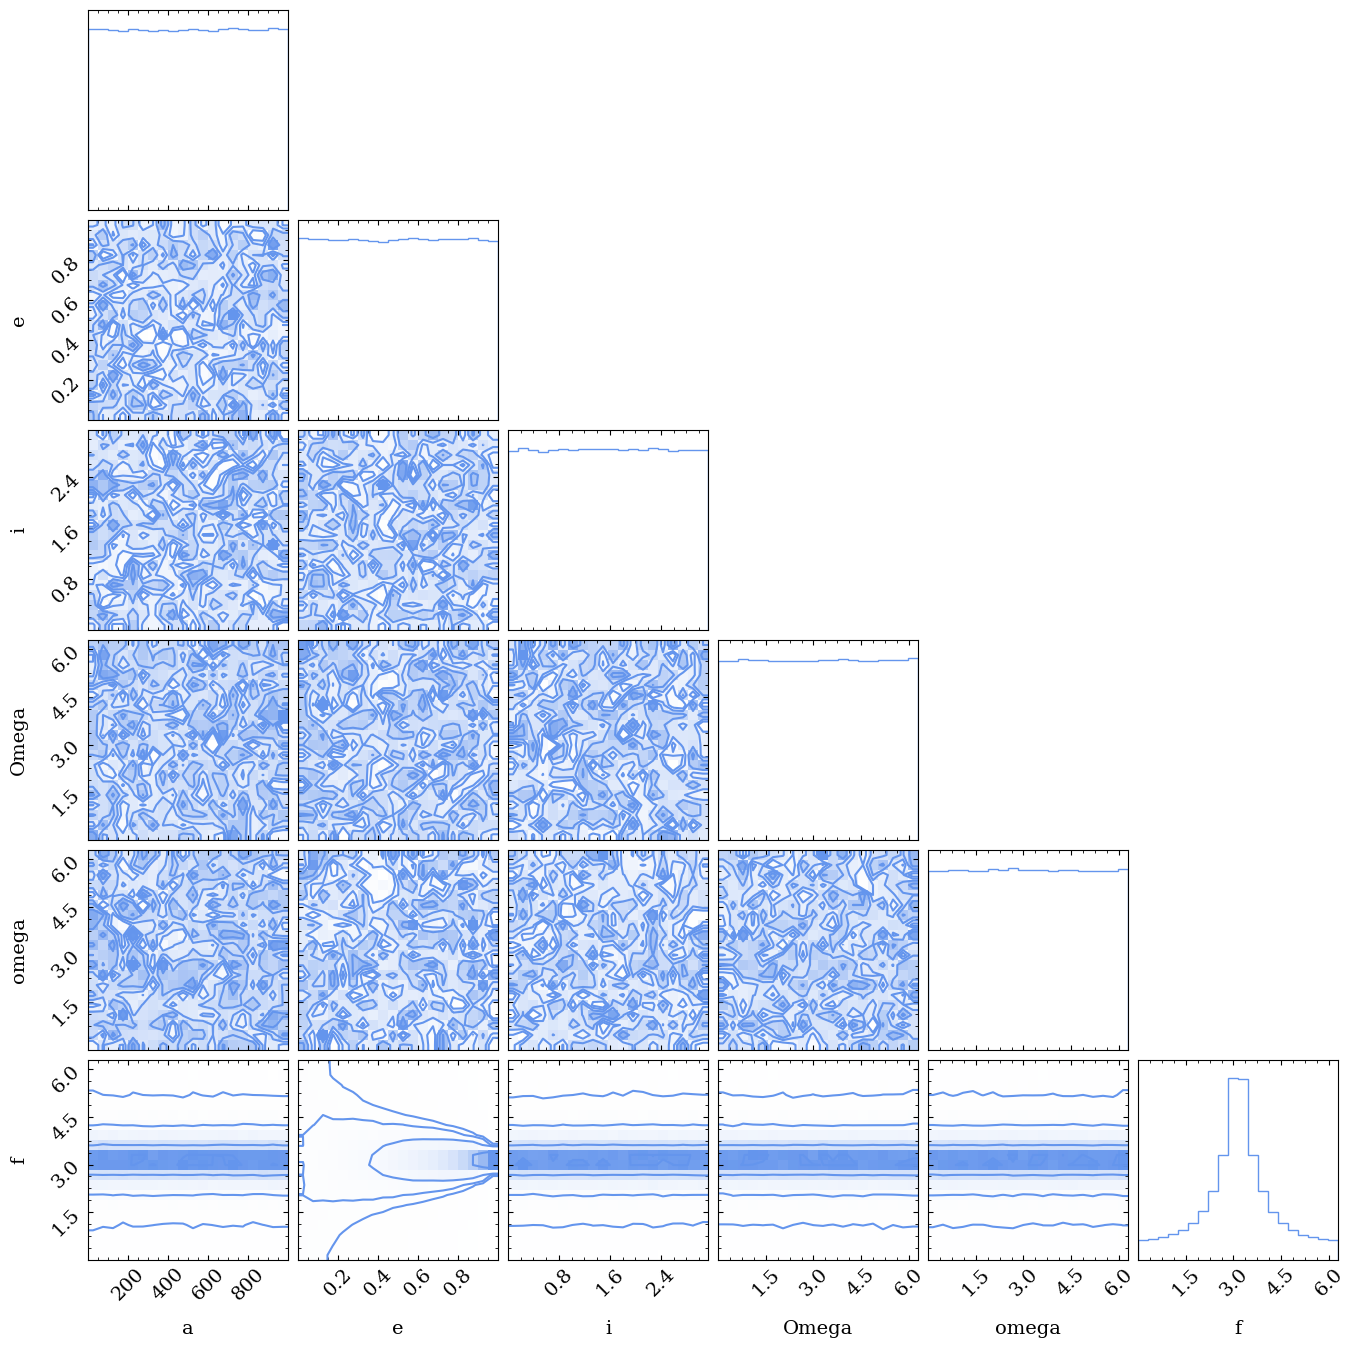

In [30]:
u = np.random.uniform(0, 1, (1_000_000, 7))
orbs = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0, None,None,None))(u, 1.0, 1000.0, True)

corner.corner(np.array(orbs[:,:-1]), labels=['a', 'e', 'i', 'Omega', 'omega', 'f'], color="cornflowerblue", plot_datapoints=False);

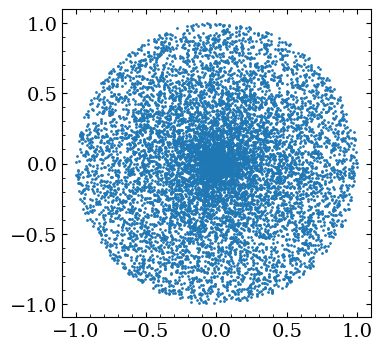

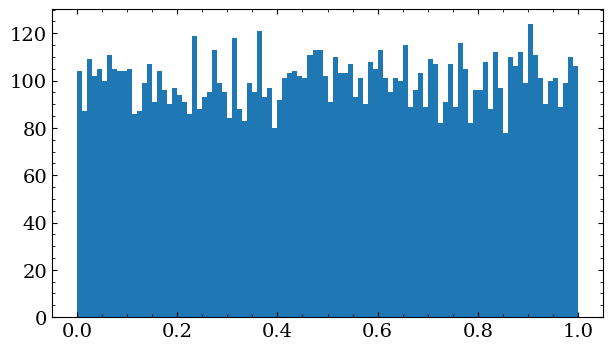

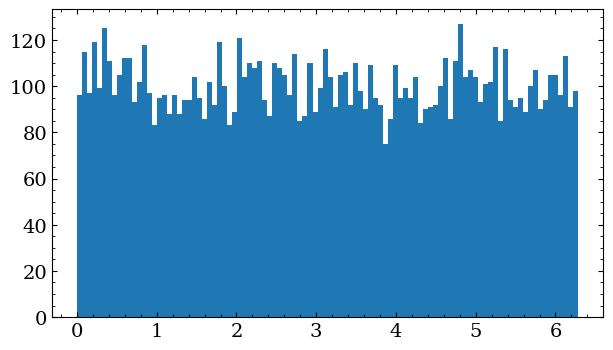

In [14]:
# r = np.sqrt(np.random.uniform(0, 1, 10_000))
# want a biased r to get uniform e
r = np.random.uniform(0, 1, 10_000)
theta = np.random.uniform(0, 2*np.pi, 10_000)

h = r * np.cos(theta)
k = r * np.sin(theta)

e = np.sqrt(h**2 + k**2)
omega = np.arctan2(h, k) + np.pi

fig, ax = plt.subplots()
ax.scatter(h, k, s=1)
ax.set_aspect('equal', 'box')
plt.figure()
plt.hist(e, bins=100)
plt.figure()
plt.hist(omega, bins=100);


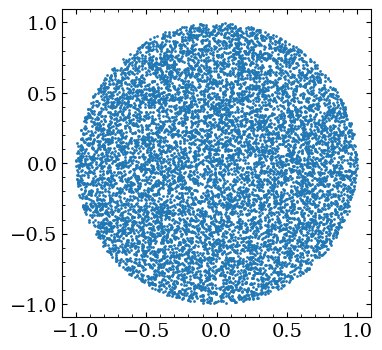

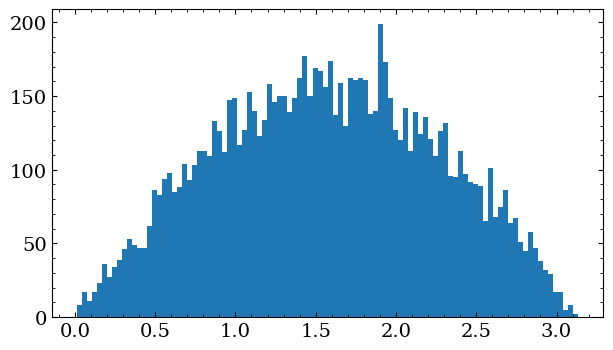

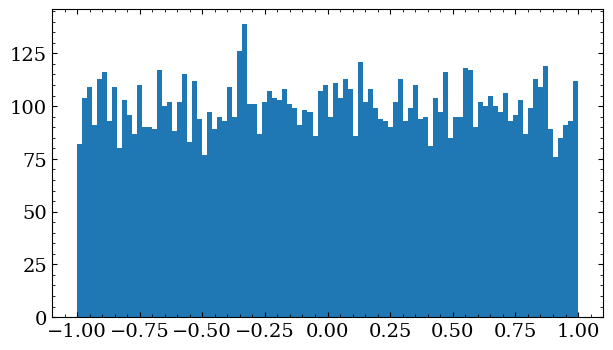

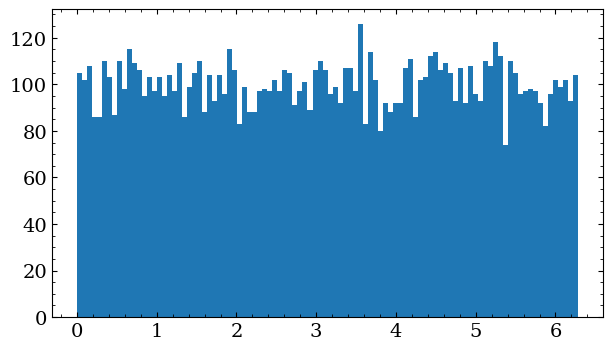

In [18]:
# here though, the
r = np.sqrt(np.random.uniform(0, 1, 10_000))
theta = np.random.uniform(0, 2*np.pi, 10_000)

p = r * np.cos(theta)
q = r * np.sin(theta)

i = 2 * np.arcsin(np.sqrt(p**2 + q**2))
Omega = np.arctan2(q, p) + np.pi

fig, ax = plt.subplots()
ax.scatter(p, q, s=1)
ax.set_aspect('equal', 'box')
plt.figure()
plt.hist(i, bins=100)
plt.figure()
plt.hist(np.cos(i), bins=100)
plt.figure()
plt.hist(Omega, bins=100);

In [4]:
def unit_cube_to_orbital_elements(u, a_low, a_high):
    # for ecc, omega, don't correct for uniform r:
    # biased samples on unit disk -> uniform e
    _r = u[0]
    _z1 = jax.scipy.stats.norm.ppf(u[1])
    _z2 = jax.scipy.stats.norm.ppf(u[2])
    h = _r * _z1
    k = _r * _z2
    e = _r
    omega = jnp.arctan2(h, k) + jnp.pi

    _r = jnp.sqrt(u[3]) # this gives us uniform cos(i)
    # _r = jnp.sin(jnp.pi * u[3] / 2) # this gives us uniform i
    _z1 = jax.scipy.stats.norm.ppf(u[4])
    _z2 = jax.scipy.stats.norm.ppf(u[5])
    p = _r * _z1
    q = _r * _z2
    i = 2 * jnp.arcsin(_r)
    Omega = jnp.arctan2(q, p) + jnp.pi

    # a = (u[4])**(1/3) * (a_high - a_low) + a_low # this gives us uniform volume density, circ orbits
    a = u[6] * (a_high - a_low) + a_low

    _z1 = jax.scipy.stats.norm.ppf(u[7])
    _z2 = jax.scipy.stats.norm.ppf(u[8])
    lamb = jnp.arctan2(_z2, _z1)
    M = lamb - omega - Omega
    f = kepler(M, e)

    return jnp.array([a, e, i, Omega, omega, f])

u = np.random.uniform(0, 1, (10_000, 9))
orbital_elements = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0, None, None))(u, 1, 100)

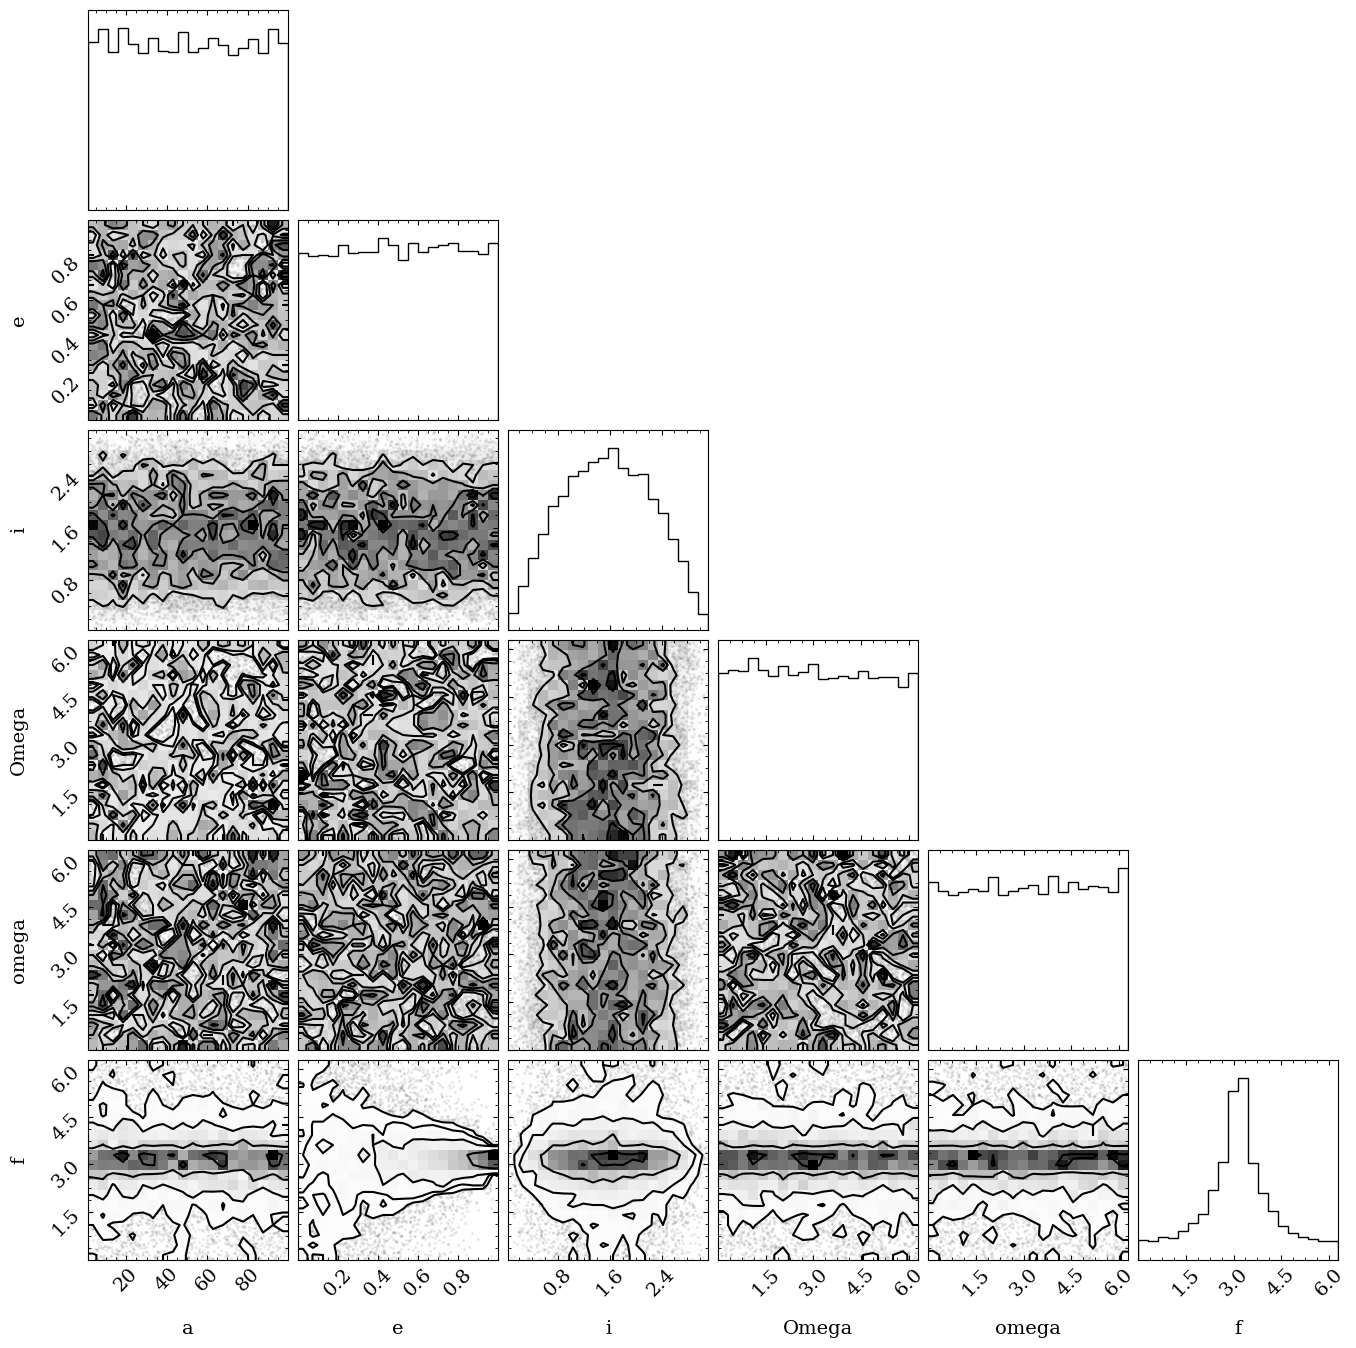

In [5]:
import corner

corner.corner(np.array(orbital_elements), labels=['a', 'e', 'i', 'Omega', 'omega', 'f']);

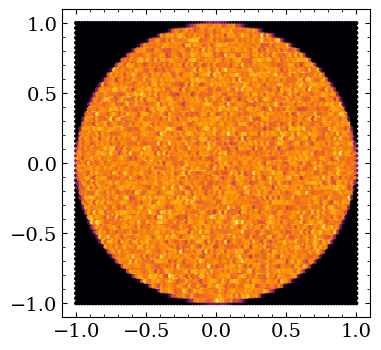

In [81]:
@jax.jit
def test2(a,b):

    flag1 = a > -b
    flag2 = a > b
    flag3 = a < b

    r = (a * flag1*flag2) + (b * flag1*~flag2) + (-a * ~flag1*flag3) + (-b * ~flag1*~flag3)
    phi = (
        (((jnp.pi / 4) * (b / a)) * flag1*flag2) +
        ((jnp.pi / 4) * (2 - (a / b)) * flag1*~flag2) +
        ((jnp.pi / 4) * (4 + (b / a)) * ~flag1*flag3) +
        ((jnp.pi / 4) * (6 - (a / b)) * ~flag1*~flag3)
    )

    x = r * jnp.cos(phi)
    y = r * jnp.sin(phi)
    return jnp.array([x, y])

a = np.random.uniform(-1, 1, 1_000_000)
b = np.random.uniform(-1, 1, 1_000_000)
x, y = test2(a, b)

fig, ax = plt.subplots()
ax.hexbin(x, y, gridsize=100, cmap='inferno')
ax.set_aspect('equal', 'box')

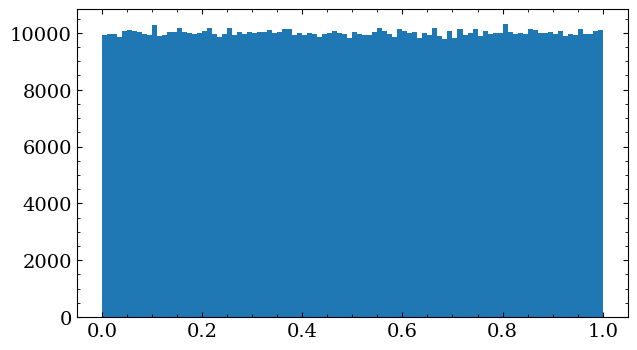

In [83]:
r = jnp.sqrt(x**2 + y**2)
plt.hist(r**2, bins=100);

In [2]:
@jax.jit
def square_to_unit_disk(a,b):
    # https://doi.org/10.1080/10867651.1997.10487479
    a = 2 * a - 1
    b = 2 * b - 1

    flag1 = a > -b
    flag2 = a > b
    flag3 = a < b

    r = (a * flag1*flag2) + (b * flag1*~flag2) + (-a * ~flag1*flag3) + (-b * ~flag1*~flag3)
    phi = (
        (((jnp.pi / 4) * (b / a)) * flag1*flag2) +
        ((jnp.pi / 4) * (2 - (a / b)) * flag1*~flag2) +
        ((jnp.pi / 4) * (4 + (b / a)) * ~flag1*flag3) +
        ((jnp.pi / 4) * (6 - (a / b)) * ~flag1*~flag3)
    )

    return r, phi

    # x = r * jnp.cos(phi)
    # y = r * jnp.sin(phi)
    # return x, y

@jax.jit
def unit_disk_to_square(r, phi):
    # inverse of square_to_unit_disk

    # r = jnp.sqrt(x**2 + y**2)
    # phi = jnp.arctan2(y, x)
    # phi = jnp.mod(phi, 2 * jnp.pi)

    # We now decide which branch to use based on phi.
    # Note:
    #   Branch 1 corresponds to points with effective angle in [-pi/4, pi/4].
    #   After wrapping, that means phi in [0, pi/4] and also phi in (7pi/4, 2pi).
    cond1 = (phi <= jnp.pi/4) | (phi > 7 * jnp.pi/4)
    # Branch 2: phi in (pi/4, 3pi/4]
    cond2 = (phi > jnp.pi/4) & (phi <= 3 * jnp.pi/4)
    # Branch 3: phi in (3pi/4, 5pi/4]
    cond3 = (phi > 3 * jnp.pi/4) & (phi <= 5 * jnp.pi/4)
    # Branch 4: phi in (5pi/4, 7pi/4]
    cond4 = (phi > 5 * jnp.pi/4) & (phi <= 7 * jnp.pi/4)

    # Initialize A and B (in [-1,1]).
    A = jnp.zeros_like(r)
    B = jnp.zeros_like(r)

    # Branch 1:
    # For numerical consistency, if phi > 7pi/4 we subtract 2pi so that the effective phi is negative.
    phi1 = jnp.where(phi > 7 * jnp.pi/4, phi - 2 * jnp.pi, phi)
    A = jnp.where(cond1, r, A)
    B = jnp.where(cond1, (4 * r / jnp.pi) * phi1, B)

    # Branch 2:
    # Here, r = B and phi = (pi/4)*(2 - A/B)  =>  A = B*(2 - (4/π)*phi)
    A = jnp.where(cond2, r * (2 - (4/ jnp.pi) * phi), A)
    B = jnp.where(cond2, r, B)

    # Branch 3:
    # Here, r = -A and phi = (pi/4)*(4 + B/A)  =>  A = -r, B = r*(4 - (4/π)*phi)
    A = jnp.where(cond3, -r, A)
    B = jnp.where(cond3, r * (4 - (4/ jnp.pi) * phi), B)

    # Branch 4:
    # Here, r = -B and phi = (pi/4)*(6 - A/B)  =>  B = -r, A = r*((4/π)*phi - 6)
    A = jnp.where(cond4, r * ((4/ jnp.pi) * phi - 6), A)
    B = jnp.where(cond4, -r, B)

    # Convert from A, B in [-1, 1] back to a, b in [0,1]
    a = (A + 1) / 2
    b = (B + 1) / 2
    return a, b

a = np.random.uniform(0, 1, 100_000)
b = np.random.uniform(0, 1, 100_000)

x, y = square_to_unit_disk(a, b)
a_, b_ = unit_disk_to_square(x, y)

jnp.max(jnp.abs(a - a_)), jnp.max(jnp.abs(b - b_))

(Array(6.66133815e-16, dtype=float64), Array(3.88578059e-16, dtype=float64))

In [21]:
def unit_cube_to_orbital_elements(u, a_low, a_high):

    _r, _theta = square_to_unit_disk(u[0], u[1])
    _r = _r**2 # this gives us uniform e
    h = _r * jnp.cos(_theta)
    k = _r * jnp.sin(_theta)
    e = _r
    omega = jnp.arctan2(h, k) + jnp.pi

    _r, _theta = square_to_unit_disk(u[2], u[3])
    _r = jnp.sin(jnp.pi * _r**2 / 2) # this gives us uniform i
    p = _r * jnp.cos(_theta)
    q = _r * jnp.sin(_theta)
    i = 2 * jnp.arcsin(_r)
    Omega = jnp.arctan2(q, p) + jnp.pi

    a = u[4] * (a_high - a_low) + a_low

    _r, _theta = square_to_unit_disk(u[5], u[6])
    lamb = _theta
    lamb = jnp.where(lamb < 0, lamb + 2 * jnp.pi, lamb)
    M = lamb - omega - Omega
    M = jnp.where(M < 0, M + 2 * jnp.pi, M)
    f = kepler(M, e)

    return jnp.array([a, e, i, Omega, omega, f, _r])

def orbital_elements_to_unit_cube(orb, a_low, a_high):
    a, e, i, Omega, omega, f, r3 = orb

    theta1 = 3 * jnp.pi / 2 - omega
    theta1 = jnp.where(theta1 < 0, theta1 + 2 * jnp.pi, theta1)
    r1 = jnp.sqrt(e)
    u0, u1 = unit_disk_to_square(r1, theta1)

    r2 = jnp.sin(i / 2)
    r2 = jnp.sqrt(2 / jnp.pi) * jnp.sqrt(jnp.arcsin(r2)) # this is necessary if we were doing uniform i instead of uniform cos(i)
    theta2 = Omega - jnp.pi
    theta2 = jnp.where(theta2 < 0, theta2 + 2 * jnp.pi, theta2)
    u2, u3 = unit_disk_to_square(r2, theta2)

    u4 = (a - a_low) / (a_high - a_low)

    M = M_from_f(f, e)  # This function must be provided.
    lamb = M + omega + Omega
    lamb = jnp.where(lamb < 0, lamb+ 2 * jnp.pi, lamb)
    lamb = jnp.mod(lamb, 2 * jnp.pi)
    u5, u6 = unit_disk_to_square(r3, lamb)

    return jnp.array([u0, u1, u2, u3, u4, u5, u6])

u = np.random.uniform(0, 1, (10_000, 7))
orb = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0,None,None))(u, 1, 100)

u_ = jax.vmap(orbital_elements_to_unit_cube, in_axes=(0,None,None))(orb, 1, 100)

jnp.max(jnp.abs(u - u_))

Array(1.8861579e-12, dtype=float64)

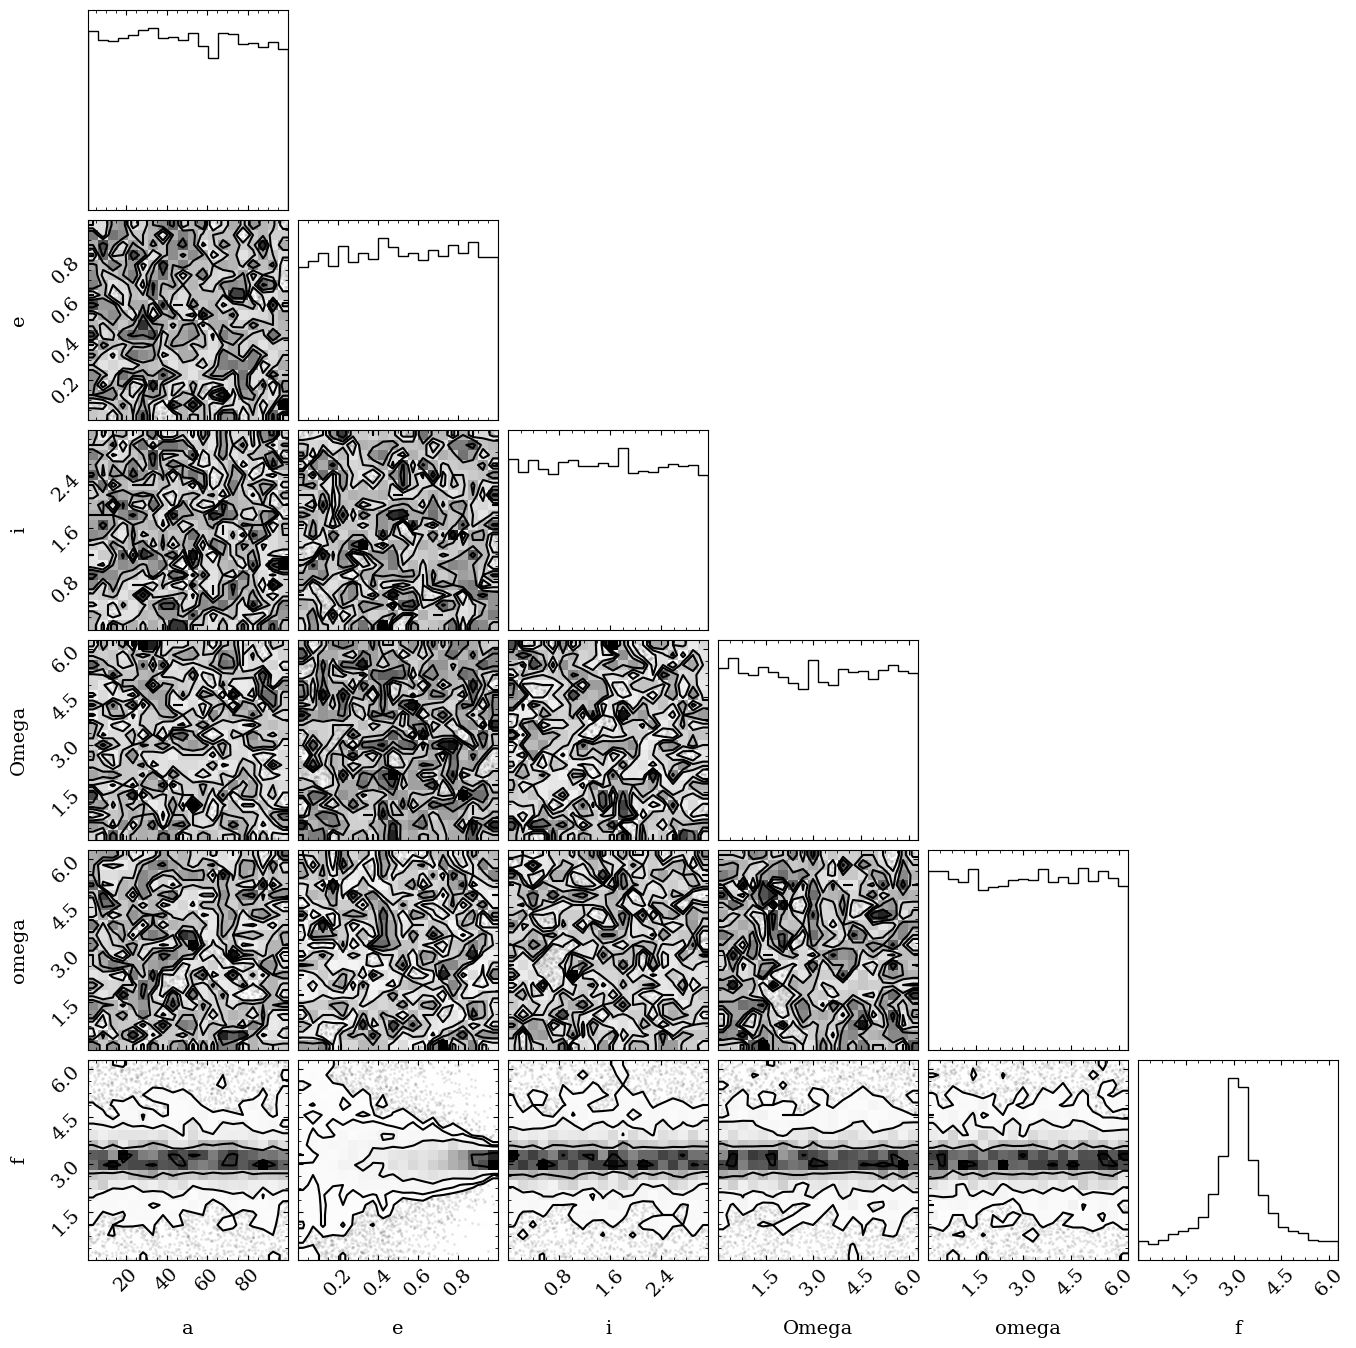

In [14]:
u = np.random.uniform(0, 1, (10_000, 7))
orbs = jax.vmap(unit_cube_to_orbital_elements, in_axes=(0,None,None))(u, 1, 100)


corner.corner(np.array(orbs[:,:-1]), labels=['a', 'e', 'i', 'Omega', 'omega', 'f']);

In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import astropy.units as u
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astroquery.jplhorizons import Horizons

from jorbit import Observations, Particle

In [2]:
nights = [Time("2025-01-01 07:00"), Time("2025-01-02 07:00"), Time("2025-01-05 07:00")]

times = []
for n in nights:
    times.extend([n + i * 1 * u.hour for i in range(3)])
times = Time(times)


obj = Horizons(id="274301", location="695@399", epochs=times.utc.jd)
# obj = Horizons(id="90377", location="695@399", epochs=times.utc.jd)
pts = obj.ephemerides(extra_precision=True, quantities="1")

coords = SkyCoord(pts["RA"], pts["DEC"], unit=(u.deg, u.deg))
times = Time(pts["datetime_jd"], format="jd", scale="utc")


obs = Observations(
    observed_coordinates=coords,
    times=times,
    observatories="kitt peak",
    astrometric_uncertainties=1 * u.arcsec,
)


obj = Horizons(id="274301", location="500@0", epochs=times.tdb.jd[0])
# obj = Horizons(id="90377", location="500@0", epochs=times.tdb.jd[0])
vecs = obj.vectors(refplane="earth")
true_x0 = jnp.array([vecs["x"], vecs["y"], vecs["z"]]).T[0]
true_v0 = jnp.array([vecs["vx"], vecs["vy"], vecs["vz"]]).T[0]


p0 = Particle(
    x=true_x0, v=true_v0, time=times[0], name="274301 Wikipedia", observations=obs
)
# p0 = Particle(
#     x=true_x0, v=true_v0, time=times[0], name="90377 Sedna", observations=obs,
# )
p0

Particle: 274301 Wikipedia